# 微分方程模型

**用sympy和scipy**

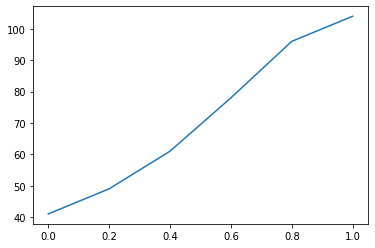

In [86]:
# 一些参数. 来自15.2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


x0 = np.array([41, 49, 61, 78, 96, 104], dtype=np.float)
plt.plot(np.linspace(0, 1, x0.shape[0]), x0)
plt.show()
lamb = np.array([x0[i] / x0[i+1] for i in range(x0.shape[0]-1)])
Theta = (np.exp(-2/(x0.shape[0]+1)), np.exp(2/(x0.shape[0]+2)))
OK = [i <= Theta[1] and i >= -Theta[0] for i in lamb]
x1 = np.array([x0[:i].sum() for i in range(1, x0.shape[0]+1)])
alpha1_x0 = np.array([x0[i] - x0[i-1] for i in range(1, x0.shape[0])])
z1 = np.array([(x1[i]+x1[i+1])/2 for i in range(x1.shape[0]-1)])
B = np.array(np.c_[-x0[1:], -z1, np.ones(z1.shape[0])])
Y = alpha1_x0
u = np.matmul(np.linalg.inv(np.matmul(B.T, B)), np.matmul(B.T, Y))
a1, a2, b = u[0], u[1], u[2]
x1_t = lambda k: (x0[0] - b/a) * np.exp(-a*k) + b/a

In [88]:
# sympy的一个例子
# 参考: https://blog.csdn.net/and_w/article/details/80160033
import sympy

sympy.init_printing
# 定义符号常量x 与 f(x)
t = sympy.Symbol('t')
a1, a2, b = sympy.symbols('a1, a2, b')
x1_t = sympy.Function('x1_t')
# 微分方程ode
ode = sympy.Eq(x1_t(t).diff(t, t) + a1*x1_t(t).diff(t) + a2*x1_t(t), b)
init1 = sympy.Eq(x1_t(0), x1[0])
init2 = sympy.Eq(x1_t(1), x1[1])
# 调用dsolve函数,返回一个Eq对象，hint控制精度
ode_sol = sympy.dsolve((ode), x1_t(t))
print('得到带参符号解:', ode_sol)

# 初始条件字典
x1_to_value = {x1_t(0): 41, x1_t(x1.shape[0]-1): x1[-1]}
# 确定待定常数集
known_params = {a1, a2, b, t}
free_params = ode_sol.free_symbols - set(known_params)
# 将初始条件带入微分方程的后得到的多元方程
C_eqs = [sympy.Eq(ode_sol.lhs.subs(t, 0).subs(x1_to_value), ode_sol.rhs.subs(t, 0)),
         sympy.Eq(ode_sol.lhs.subs(t, x1.shape[0]).subs(x1_to_value), ode_sol.rhs.subs(t, x1.shape[0]))
        ]
print('待定常数: ', free_params)
print('关于待定常数的多元方程组:', C_eqs, sep='\n')
sol_params = sympy.solve(C_eqs, free_params)
print('解得待定常数:', sol_params)
final_sol_eq = sympy.Eq(ode_sol.lhs, ode_sol.rhs.subs(sol_params))
print('最终解:', final_sol_eq.lhs, '=', final_sol_eq.rhs)

得到带参符号解: Eq(x1_t(t), C1*exp(t*(-a1 - sqrt(a1**2 - 4*a2))/2) + C2*exp(t*(-a1 + sqrt(a1**2 - 4*a2))/2) + b/a2)
待定常数:  {C2, C1}
关于待定常数的多元方程组:
[Eq(41, C1 + C2 + b/a2), Eq(x1_t(6), C1*exp(-3*a1 - 3*sqrt(a1**2 - 4*a2)) + C2*exp(-3*a1 + 3*sqrt(a1**2 - 4*a2)) + b/a2)]
解得待定常数: {C1: ((41*a2 - b)*exp(3*a1 + 6*sqrt(a1**2 - 4*a2)) - (a2*x1_t(6) - b)*exp(6*a1 + 3*sqrt(a1**2 - 4*a2)))*exp(-3*a1)/(a2*(exp(6*sqrt(a1**2 - 4*a2)) - 1)), C2: -((41*a2 - b)*exp(3*a1) - (a2*x1_t(6) - b)*exp(6*a1 + 3*sqrt(a1**2 - 4*a2)))*exp(-3*a1)/(a2*(exp(6*sqrt(a1**2 - 4*a2)) - 1))}
最终解: x1_t(t) = b/a2 - ((41*a2 - b)*exp(3*a1) - (a2*x1_t(6) - b)*exp(6*a1 + 3*sqrt(a1**2 - 4*a2)))*exp(-3*a1)*exp(t*(-a1 + sqrt(a1**2 - 4*a2))/2)/(a2*(exp(6*sqrt(a1**2 - 4*a2)) - 1)) + ((41*a2 - b)*exp(3*a1 + 6*sqrt(a1**2 - 4*a2)) - (a2*x1_t(6) - b)*exp(6*a1 + 3*sqrt(a1**2 - 4*a2)))*exp(-3*a1)*exp(t*(-a1 - sqrt(a1**2 - 4*a2))/2)/(a2*(exp(6*sqrt(a1**2 - 4*a2)) - 1))


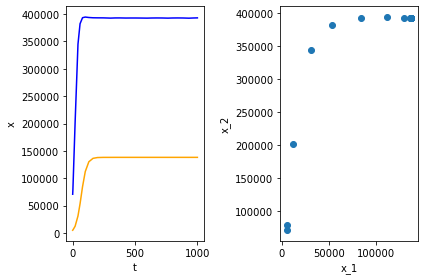

In [20]:
# scipy.integrate.RK45
# 用龙格库塔法解一阶微分方程组

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import RK45


def funcs(t, x):
    dxdt = np.zeros(2)
    a = 1e-8
    dxdt[0] = 0.05*x[0]*(1-x[0]/150000)-a*x[0]*x[1];
    dxdt[1] = 0.08*x[1]*(1-x[1]/400000)-a*x[0]*x[1];
    return dxdt


t0 = 0
y0 = [5000, 70000]
t_bound = 1000

rk45 = RK45(fun=funcs, t0=t0, y0=y0, t_bound=t_bound)

t = []
x = [[], []]

while rk45.status == 'running':
    rk45.step()
    t.append(rk45.t)
    x[0].append(rk45.y[0])
    x[1].append(rk45.y[1])
plt.subplot(1, 2, 1)
plt.plot(t, x[0], color='orange')
plt.plot(t, x[1], color='b')
plt.xlabel(u't')
plt.ylabel(u'x')
plt.subplot(1, 2, 2)
plt.scatter(x[0], x[1])
plt.xlabel(u'x_1')
plt.ylabel(u'x_2')

plt.tight_layout()
plt.show()